# Surface Water-Mass Transformation

In this recipe, we compute surface water-mass transformation rates (both in the net and partitioned into contributions from heat and salt fluxes) for the southern ocean, south of 60S.

This recipe is set up to run with MOM6 simulations. You should read the diagnostics in the `get_variables` function and add/remove according to your needs. Notice that a different set of diagnostics has to be used when adapting this code to run with MOM5 simulations. Directions on how to change the diagnostic fields to run the code with MOM5 simulations are under the *requirements section*.

This code runs smoothly for *panant-01-zstar-ACCESSyr2* experiment, under the normal queue, with X-large memory settings. Finer resolutions might require more memory.

## 1. Defining surface water-mass transformation

The surface water-mass transformation framework described here follows [Newsom *et al* (2016)](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-15-0513.1) and [Abernathey *et al* (2016)](https://www.nature.com/articles/ngeo2749). Surface water-mass transformation may be defined as the volume flux into a given density class ($\sigma$) from lighter density classes ($\sigma'<\sigma$) due to surface buoyancy forcing. Integrated over a region of the ocean surface, this volume flux can be expressed as,

$$
\begin{equation}
\Omega(\sigma, t) = \frac{\partial}{\partial\sigma} \iint_{\sigma'<\sigma} \Big(\frac{\partial\sigma}{\partial\theta}\theta + \frac{\partial\sigma}{\partial S}S\Big) \, \mathrm{d}x \, \mathrm{d}y
\end{equation}
$$

where $t$ is time, and the terms in the integrand are the potential temperature ($\theta$) flux and salinity ($S$) flux components of the surface buoyancy flux. The linearity of this expression means we can extract the relative contributions of heat ($\Omega_\text{heat}$) and salinity ($\Omega_\text{fw}$) fluxes to surface water-mass transformation, highlighting driving mechanisms.

## 2. Requirements

**Analysis environment:** The conda/analysis3-25.05 (or later) module on NCI. This is available via the `xp65` project.

**Model diagnostics:** This notebook is set up to work with MOM6 simulations, and uses the folowing monthly diagnostics: 


| Variable| Diagnostic field | 
| --- | --- | 
| Temperature | `thetao` | 
| Salinity| `so` | 
| Water flux into ocean | `wfo` | 
| Salt flux| `salt_flux` | 
| Surface heat flux | `hfds` | 
| Surface area| `areacello` | 
| Ocean depth| `deptho` | 

The code code also integrates the surface fluxes zonally (i.e., along `xh` in MOM6) and meridionally (along `yh`).
_______
**Warning**: A different set monthly diagnostics is required to run this code with ACCESS-OM2 (MOM5) outputs. They are:


| Variable| Diagnostic field | 
| --- | --- | 
| Temperature | `temp` | 
| Salinity| `salt` | 
| Water flux into ocean | `pme_river` | 
| Salt flux| `sfc_salt_flux_ice` + `sfc_salt_flux_restore` | 
| Surface heat flux | `sfc_hflux_coupler`+`sfc_hflux_from_runoff`+`frazil_3d_int_z`+ `sfc_hflux_pme` | 
| Surface Area| `area_t` | 
| Ocean depth| `ht` | 

Notice that for MOM5 you will have to import the diagnostic fields for each variable and sum them into the target variable, e.g.,


`salt_flux  =  sfc_salt_flux_ice + sfc_salt_flux_restore` 


Finally, zonal integration should be done along `xt_ocean` and meridional integration along `yt_ocean`.



In [1]:
import cartopy.crs as ccrs
import cmocean as cm
import dask.distributed
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
import pdb
import os
import pathlib
import shutil

import intake
cat = intake.cat.access_nri

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

# Set temp_dir to a directory to store ~8GB of temporary output files
temp_dir = os.path.expandvars("/scratch/$PROJECT/$USER/temp/swmt")
temp_path = pathlib.Path(temp_dir)

# Ensure a fresh start
if temp_path.exists():
    shutil.rmtree(temp_path)  # Delete the directory and all its contents
temp_path.mkdir(parents=True, exist_ok=True)  # Create it again

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)

# Computing surface water mass transformation

We will do this by defining three functions. The first one loads the diagnostics needed. The second one **actually calculates the transformations**, and a third one does the density binning.

In [3]:
def get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice):
        # Load variables required for the Surface Water Mass Transformation
    ds = {}
    #Setting the time slice
    time_slice=slice(start_time,end_time)
    # Getting surface fluxes
    #Importing water flux into ocean
    wfo = cat[expt].search(variable="wfo",frequency=freq)\
            .to_dask(xarray_open_kwargs={"decode_timedelta": False})["wfo"].sel(xh = lon_slice, yh = lat_slice,time = time_slice).compute()
    #Importing salt flux into ocean - includes salt flux from sea ice and restoring
    salt_flux = cat[expt].search(variable="salt_flux",frequency=freq)\
            .to_dask(xarray_open_kwargs={"decode_timedelta": False})["salt_flux"].sel(xh = lon_slice, yh = lat_slice,time = time_slice).compute()
    # importing heat fluxes "hfds"
    heat_flux = cat[expt].search(variable="hfds",frequency=freq)\
            .to_dask(xarray_open_kwargs={"decode_timedelta": False})["hfds"].sel(xh = lon_slice, yh = lat_slice,time = time_slice).compute()

    # # Get temperature and salinity to calculate few other things we'll need later on
    #Importing practical salinity
    SP = cat[expt].search(variable="so",frequency=freq)\
            .to_dask(xarray_open_kwargs={"decode_timedelta": False})["so"].sel(xh = lon_slice, yh = lat_slice,time = time_slice).isel(z_l=0)
    #importing conservative temperature
    CT = cat[expt].search(variable="thetao",frequency=freq)\
            .to_dask(xarray_open_kwargs={"decode_timedelta": False})["thetao"].sel(xh = lon_slice, yh = lat_slice,time = time_slice).isel(z_l=0).compute()
    Temp_type= CT.attrs['long_name']
    if Temp_type == 'Sea Water Potential Temperature':
        print('Sea Water Potential Temperature will be converted to Conservative Temperature' )
    #importing area
    area = cat[expt].search(variable="areacello")\
            .to_dask(xarray_open_kwargs={"decode_timedelta": False})["areacello"].sel(xh = lon_slice, yh = lat_slice).compute()
    #importing maximum depth
    maximum_depth = cat[expt].search(variable="deptho")\
            .to_dask(xarray_open_kwargs={"decode_timedelta": False})["deptho"].sel(xh = lon_slice, yh = lat_slice).compute()
    #creating a depth array for each latitude
    surface_z = SP.z_l.values
    # # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.yh).rename('pressure').compute()

    # # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.xh, SP.yh).rename('SA').compute()

    # # Ensure we have conservative temperature; Convert MOM6's potential temperature to conservative
    #Conversion is wrapped within a "if" statement to make sure we only convert the temperature when necessary, i.e., conversion not performed with MOM5 output
    #
    if Temp_type == 'Sea Water Potential Temperature': 
        naming = CT.name
        CT = gsw.CT_from_pt(SA, CT).compute(); CT.name = naming; del naming
        # ds['temperature'][model_vars[model]['temperature'][0]].data = CT.values

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT).compute()

    # # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    ds['CT'] = CT
    ds['wfo'] = wfo
    ds["salt_flux"] = salt_flux
    ds["heat_flux"] = heat_flux
    ds["area"] = area
    ds["maximum_depth"] = maximum_depth
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

In the function below to compute the salt transformation, note that the salt fluxes have units of (kg of salt)/m²/s, while β has units of kg / (g of salt), so we need to multiply the salt fluxes by 1000. The fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs to be multiplied by SSS to convert to (g of salt)/m²/s. This gives units of (kg of water)/m² for the salt_transformation but it will later be divided by time and density and be in m/s.

In [4]:
def compute_salt_transformation(ds):
    # Multiply the water flux by absolute salinity to get it in the correct units
    water_flux_into_ocean = ds['wfo']
    water_flux_into_ocean = ds['SA'] * water_flux_into_ocean

    # Caculate the haline contraction coefficient
    haline_contraction = gsw.beta(ds['SA'], ds['CT'], ds['pressure']).rename('beta')

    # Calculate the net salt flux and multiply by 1000 to convert units
    net_salt_flux = ds['salt_flux'] * 1000

    # Note that we also multiply pme_river by absolute salinity to have the correct units
    salt_transformation = haline_contraction * (water_flux_into_ocean - net_salt_flux) * ds['days_per_month']
    salt_transformation = salt_transformation.load()

    return salt_transformation

def compute_heat_transformation(ds):
    # Calculate the thermal expansion coefficient 
    thermal_expansion = gsw.alpha(ds['SA'], ds['CT'], ds['pressure']).rename('alpha')
    
    # Calculate the net surface heating
    net_surface_heating = ds['heat_flux']
    
    # Calculate the heat transformation
    heat_transformation = thermal_expansion * net_surface_heating * ds['days_per_month']
    heat_transformation = heat_transformation.load()

    return heat_transformation

Now we need to define the isopycnal re-binning function

In [5]:
def isopycnal_bins(ds, salt_transformation, heat_transformation):

    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    # Choose appropriate bin range
    isopycnal_bins = np.arange(31, 33.5, 0.02)  # 125 bins - 31, 33.5, 0.02 (sigma1)
    #isopycnal_bins = np.concatenate([np.arange(25.0, 26.5, 0.05), np.arange(26.5, 28.5, 0.02)])  # 130 bins (sigma0)
    bin_bottoms = isopycnal_bins[:-1]
    isopycnal_bin_mid = (isopycnal_bins[1:] + bin_bottoms) / 2
    isopycnal_bin_diff = np.diff(isopycnal_bins)

    pot_rho_1 = ds['pot_rho_1']

    results_salt = []
    results_heat = []

    for i in range(len(bin_bottoms)):
        # Create binary mask for each bin
        bin_mask = xr.where((pot_rho_1 > bin_bottoms[i]) & (pot_rho_1 <= isopycnal_bins[i + 1]), 1, np.nan)

        # Multiply and sum over time
        salt_sum = (salt_transformation * bin_mask).sum(dim='time')
        heat_sum = (heat_transformation * bin_mask).sum(dim='time')

        results_salt.append(salt_sum.expand_dims({'isopycnal_bins': [isopycnal_bin_mid[i]]}))
        results_heat.append(heat_sum.expand_dims({'isopycnal_bins': [isopycnal_bin_mid[i]]}))

    # Concatenate results along isopycnal dimension
    salt_transformation = xr.concat(results_salt, dim='isopycnal_bins')
    heat_transformation = xr.concat(results_heat, dim='isopycnal_bins')

    # Normalise by number of days and bin thickness
    ndays = ds['days_per_month'].sum()
    c_p = 3992.1 # J kg-1 degC-1

    salt_transformation /= ndays
    heat_transformation /= (c_p * ndays)

    salt_transformation /= isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation /= isopycnal_bin_diff[:, np.newaxis, np.newaxis]

    # Overwrite zeros with NANs 
    # (Note: the code within the for-loop should provide nans but lazy computing with dask can sometimes give unpredictable results)
    salt_transformation = salt_transformation.where(salt_transformation != 0)
    heat_transformation = heat_transformation.where(heat_transformation != 0)

    # Change the sign so that positive means conversion into denser water masses
    salt_transformation *= -1
    heat_transformation *= -1

    # Renaming
    salt_transformation.name = "salt_transformation"
    heat_transformation.name = "heat_transformation"

    return salt_transformation.load(), heat_transformation.load()


## Example

In [6]:
# Change to your experiment of interest
expt = 'panant-01-zstar-ACCESSyr2'
freq = '1mon'

# Select time period and region
start_time = '2004-01-01'
end_time = '2004-12-31'
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [7]:
ds = get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

Sea Water Potential Temperature will be converted to Conservative Temperature


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [8]:
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

🚨 ⏰ **Note**: the `isopycnal_bins` method below might take ~1 minute on an X-Large ARE instance, for a $0.1^o$ degree model resolution

In [9]:
%%timeit -n 1 -r 1
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)
salt_transformation_binned.to_netcdf(pathlib.Path(temp_dir, "binned_salt_transformation_mom6.nc"), mode="w")
heat_transformation_binned.to_netcdf(pathlib.Path(temp_dir, "binned_heat_transformation_mom6.nc"), mode="w")

1min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Re-loading saved transformation

In [10]:
salt_tr = xr.open_dataarray(pathlib.Path(temp_dir, "binned_salt_transformation_mom6.nc"), chunks = {'isopycnal_bins': 1})
heat_tr = xr.open_dataarray(pathlib.Path(temp_dir, "binned_heat_transformation_mom6.nc"), chunks = {'isopycnal_bins': 1})
net_tr = salt_tr + heat_tr

## Plotting

### Entire Southern Ocean south of 59S

Here, the positive peak in the high density classes indicates a rate of subduction due to surface densification processes (predominantly freshwater fluxes associated with sea-ice processes in this case). The negative peak indicates upwelling rates.

In [11]:
#multiplying transformation rates by area and integrating it horizontally to get transformation rates in Sverdrups
swmt = (ds['area'] * net_tr / 1e6).sum(['xh','yh'])
swmt_heat = (ds['area'] * heat_tr / 1e6).sum(['xh','yh'])
swmt_salt = (ds['area'] * salt_tr / 1e6).sum(['xh','yh'])

for da in [swmt, swmt_heat, swmt_salt]:
    da.attrs["units"] = "Sv"

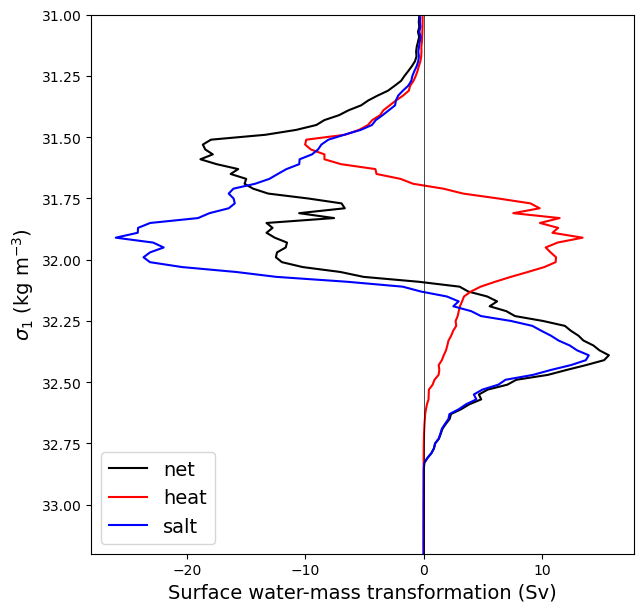

In [12]:
figure = plt.figure(figsize = (7, 7))

plt.plot(swmt, swmt['isopycnal_bins'], color = 'k', label='net')
plt.plot(swmt_heat, swmt['isopycnal_bins'], color = 'r', label='heat')
plt.plot(swmt_salt, swmt['isopycnal_bins'], color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth = 0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 14)
plt.legend(loc = 3, fontsize = 14);

### Antarctic shelf dense water formation

You might be interested in dense water formation on the Anarctic continental shelf. Below we've outlined a procedure whereby you can identify the density of subducting waters on the continental shelf, and map the locations where this sudbuction occurs.

You will need a way of masking for the continental shelf. You might just use a simple depth criterion, but here I define the shelf region using a mask that selects cells poleward of a continuous approximation of the 1000 m isobath surrounding Antarctica.

**Warning**: Shelf masking is model-specific, and is currently set up for the Pan-Antarctic simulation at 1/10th degree resolution. A mask for ACCESS-OM2-01 simulations is also available as a `.npz` file at `/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz`. When altering this code to run with ACCESS-OM2-01 first load the the above listed file using `np.load` and extract the `contour_masked_above` variable from it. If you are using a different MOM6 simulation, or a different MOM5-based model you will have to calculate your own mask. 

In [13]:
def shelf_mask_isobath(var):
    '''
    Masks Pan-Antarctic variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Christina Schmidt"
    Only to be used with ACCESS-OM2-0.1 and Pan-Antarctic output!
    '''

    path = "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc"

    var = var.sel(yh=slice(-90, -59))

    shelf_mask = xr.open_dataset(path)['contour_masked_above']

    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [14]:
depth = ds['maximum_depth']
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth)
shelf_mask_plot = shelf_mask.where((shelf_mask == 1) & (land_mask == 0))

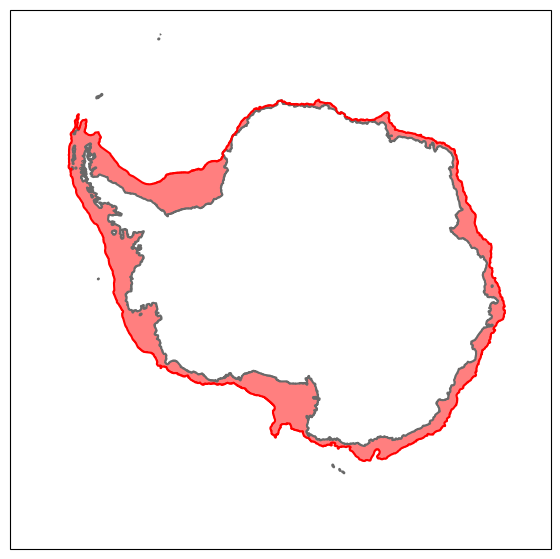

In [15]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(projection = ccrs.SouthPolarStereo())

ax.contourf(shelf_mask_plot.xh, shelf_mask_plot.yh, shelf_mask_plot,
            colors = 'red', alpha = 0.5, transform = ccrs.PlateCarree())
ax.contour(land_mask.xh, land_mask.yh, land_mask,
           levels = [0, 1], colors = 'dimgrey', transform = ccrs.PlateCarree())
ax.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask,
           levels = [0, 1], colors = 'r', transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

This shows us that continental shelf surface waters are made denser (almost entirely by sea-ice freshwater fluxes) and subduct away from the surface at a rate of over 8 Sv! Where does this happen? If we map the surface water-mass transformation rate across a chosen density class, we will be able to see where waters are subducting. We know from experience that the dense waters that overflow are best correlated with the transformation on the denser side of the peak, so let's choose $\sigma_1$ = 32.6 kg/m^3.

In [16]:
land_mask = (0 * ds['maximum_depth']).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(ds['maximum_depth'])

In [17]:
swmt_shelf = (net_tr * ds['area'] / 1e6).where(shelf_mask == 1)
heat_shelf = (heat_tr * ds['area'] / 1e6).where(shelf_mask == 1)
salt_shelf = (salt_tr * ds['area']/ 1e6).where(shelf_mask == 1)
swmt_shelf_sum = swmt_shelf.sum(['xh','yh'])
heat_shelf_sum = heat_shelf.sum(['xh','yh'])
salt_shelf_sum = salt_shelf.sum(['xh','yh'])

for da in [swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum]:
    da.attrs["units"] = "Sv"

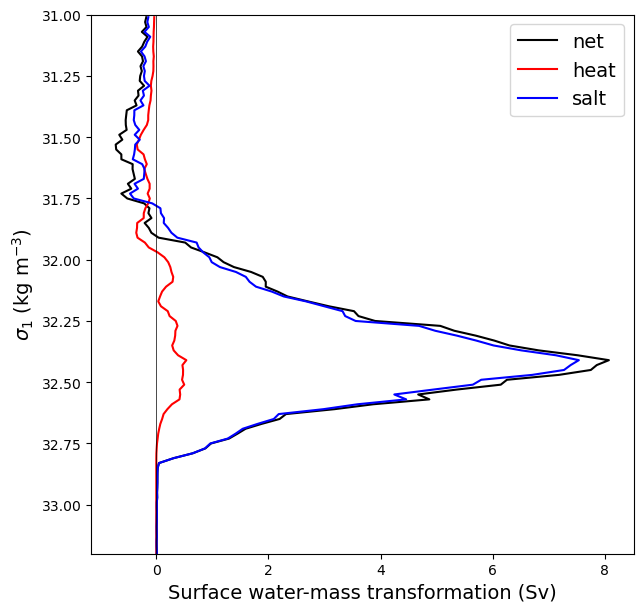

In [18]:
figure = plt.figure(figsize = (7, 7))

plt.plot(swmt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'k', label='net')
plt.plot(heat_shelf_sum, heat_shelf_sum['isopycnal_bins'], color = 'r', label='heat')
plt.plot(salt_shelf_sum, salt_shelf_sum['isopycnal_bins'], color = 'b', label='salt')
plt.plot([0, 0], [31.0, 33.2], 'k', linewidth = 0.5)

plt.ylim((33.2, 31.0))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 14)
plt.legend(loc = 1, fontsize = 14);

In [19]:
transformation_density = 32.6
shelf_subduction_plot = net_tr.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt = ds['area'].xh
swmt_yt = ds['area'].yh

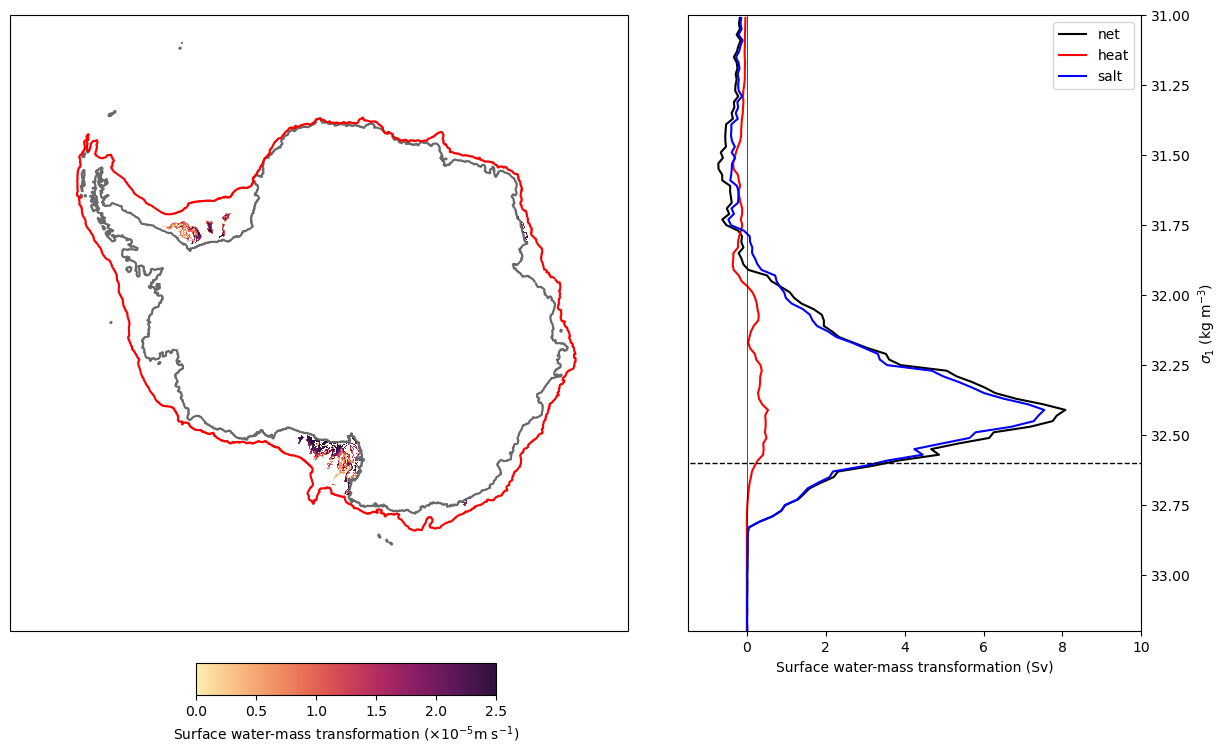

In [20]:
fig = plt.figure(1, figsize = (15, 8))
gs = gridspec.GridSpec(1, 2, width_ratios = [3, 2], wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection = ccrs.SouthPolarStereo()), plt.subplot(gs[1])
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

ax.contour(land_mask.xh, land_mask.yh, land_mask,
           levels = [0, 1], colors = 'dimgrey', transform = ccrs.PlateCarree())
ax.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask,
           levels = [0, 1], colors = 'r', transform = ccrs.PlateCarree())

norm = mcolors.Normalize(vmin = 0, vmax = 2.5)
plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot,
                          vmin = 0, vmax = 2.5,
                          cmap = cm.cm.matter,
                          transform = ccrs.PlateCarree())

cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar = plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-5}$m s$^{-1}$)')

ax1.plot(swmt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'k', label='net')
ax1.plot(heat_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'r', label='heat')
ax1.plot(salt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'b', label='salt')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15], [transformation_density, transformation_density], 'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel(r'$\sigma_1$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
ax1.legend();